In [2]:
#Importing the required libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML,display

warnings.filterwarnings("ignore")

In [3]:
#Read the daily city-wise data
df= pd.read_csv("./air-quality-dataset/city_day.csv",parse_dates=True)
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
#Keeping only the columns needed
df=df[['City','Date','AQI']]

In [5]:
#Filtering the dataframe to keep the data for the city of Delhi only
delhi = df[df['City'] == 'Delhi']
delhi.drop(['City'],axis=1,inplace = True)
delhi.set_index('Date', inplace = True)


In [6]:
delhi

,AQI
Date,
2015-01-01,472.0
2015-01-02,454.0
2015-01-03,143.0
2015-01-04,319.0
2015-01-05,325.0
...,...
2020-06-27,112.0
2020-06-28,196.0
2020-06-29,233.0


In [7]:
#Fill NULL DATA
delhi['AQI'].fillna(method = 'bfill',inplace = True)

In [8]:
#Taking monthly average
delhi=delhi.astype('float64')
delhi=delhi.resample(rule='MS').mean()

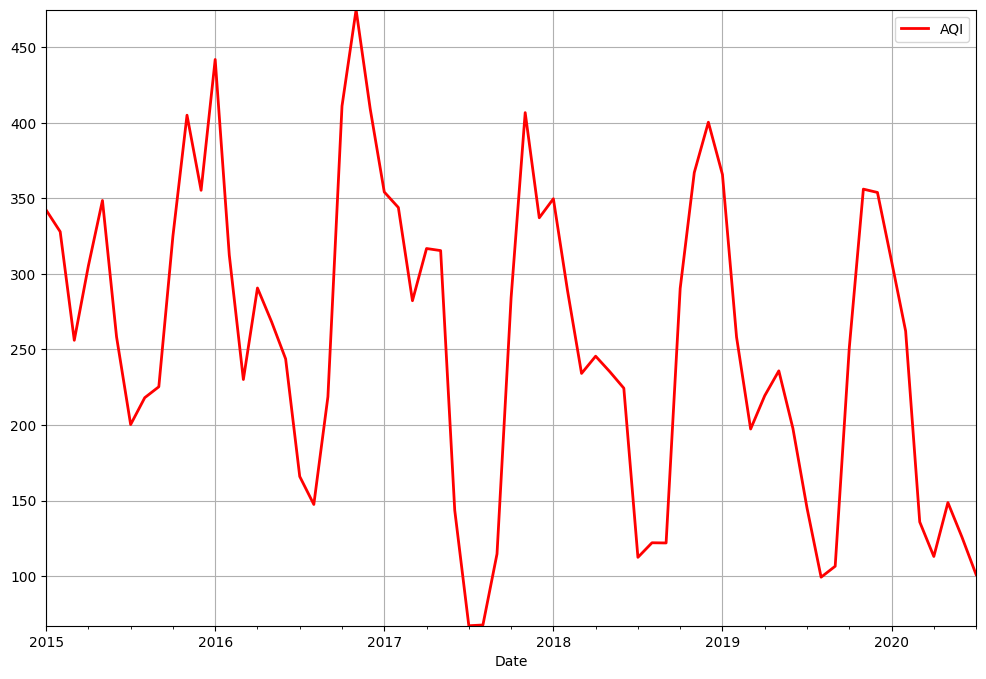

In [9]:
ax=delhi[['AQI']].plot(figsize=(12,8),grid=True,lw=2,color='Red')
ax.autoscale(enable=True, axis='both', tight=True)

# FORECASTING


In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

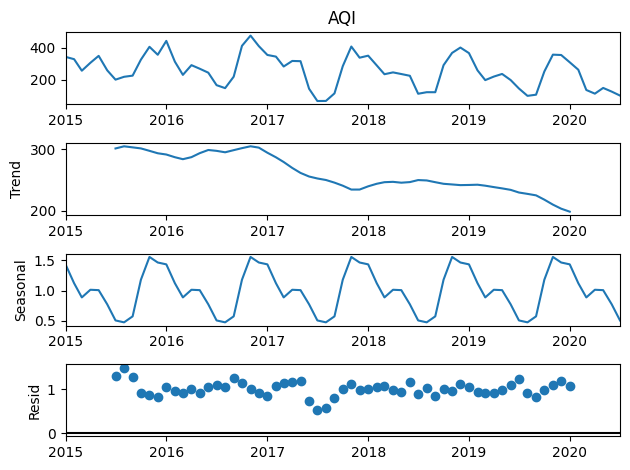

In [11]:
delhi_AQI=delhi['AQI']
result=seasonal_decompose(delhi_AQI,model='multiplicative')
result.plot();

# **SARIMAX MODEL**

In [12]:
#Importing the SARIMAX Model
from statsmodels.tsa.statespace.sarimax import SARIMAX

SARIMAX stands for Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors. It is a time series forecasting model that is an extension of the ARIMA model, where the "S" indicates the inclusion of seasonal components, and the "X" indicates the inclusion of exogenous variables. SARIMAX models are commonly used to forecast time series data that exhibit seasonal patterns and may be influenced by external factors or predictors.

In [13]:
len(delhi_AQI)

67

In [14]:
#Splitting the training and testing dataset
train=delhi_AQI[:48]
test=delhi_AQI[48:61]

In [15]:
#Defining our model and fitting on the training data
model=SARIMAX(train,order=(0,1,3),seasonal_order=(0,1,1,12))
results=model.fit()
results.summary()

c:\Users\DEVA\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                  AQI   No. Observations:                   48
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 12)   Log Likelihood                -185.444
Date:                              Fri, 17 Feb 2023   AIC                            380.888
Time:                                      12:40:53   BIC                            388.665
Sample:                                  01-01-2015   HQIC                           383.573
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5591      8.218     -0.068      0.946     -16.666      15.547
ma.L2         -0.0813      3.649     -0.022      0.982      -7.233       7.070
ma.L3         -0.3558      3.085     -0.115      0.908      -6.402       5.690
ma.S.L12      -0.9978    122.947     -0.008      0.994    -241.970     239.975
sigma2      1325.8329   1.62e+05      0.008      0.993   -3.17e+05    3.19e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.43   Prob(JB):                         0.89
Heteroskedasticity (H):               0.54   Skew:                             0.20
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
#Predicting on our train and test dataset
train_predictions = results.predict(start=1, end=48, typ='levels').rename('Predictions')
test_predictions = results.predict(start=48, end=60, typ='levels').rename('Predictions')

<AxesSubplot: xlabel='Date'>

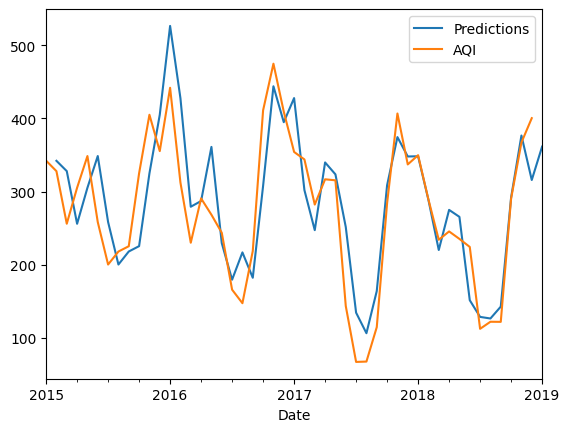

In [17]:
#Plotting the train predictions to see the fit of the model
train_predictions.plot(legend=True)
train.plot(legend=True)

In [18]:
#Calculating the RMSE value on the training dataset 
RMSE=np.sqrt(mean_squared_error(train_predictions,train))
print('RMSE = ',RMSE)
print('Mean AQI',train.mean())

RMSE =  66.39476511295446
Mean AQI 275.1711046334552


<AxesSubplot: xlabel='Date'>

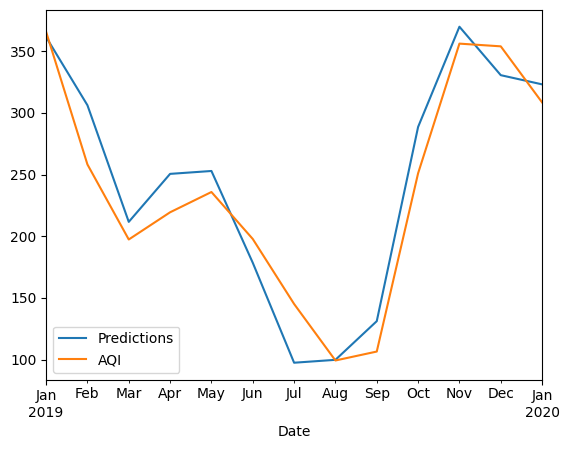

In [19]:
#Plotting the test predictions to see how well our model generalized
test_predictions.plot(legend=True)
test.plot(legend=True)

In [20]:
#Calculating the RMSE value on the testing dataset 
RMSE=np.sqrt(mean_squared_error(test_predictions,test))
print('RMSE = ',RMSE)
print('Mean AQI',test.mean())

RMSE =  26.8770462682321
Mean AQI 238.0504608294931


<AxesSubplot: xlabel='Date'>

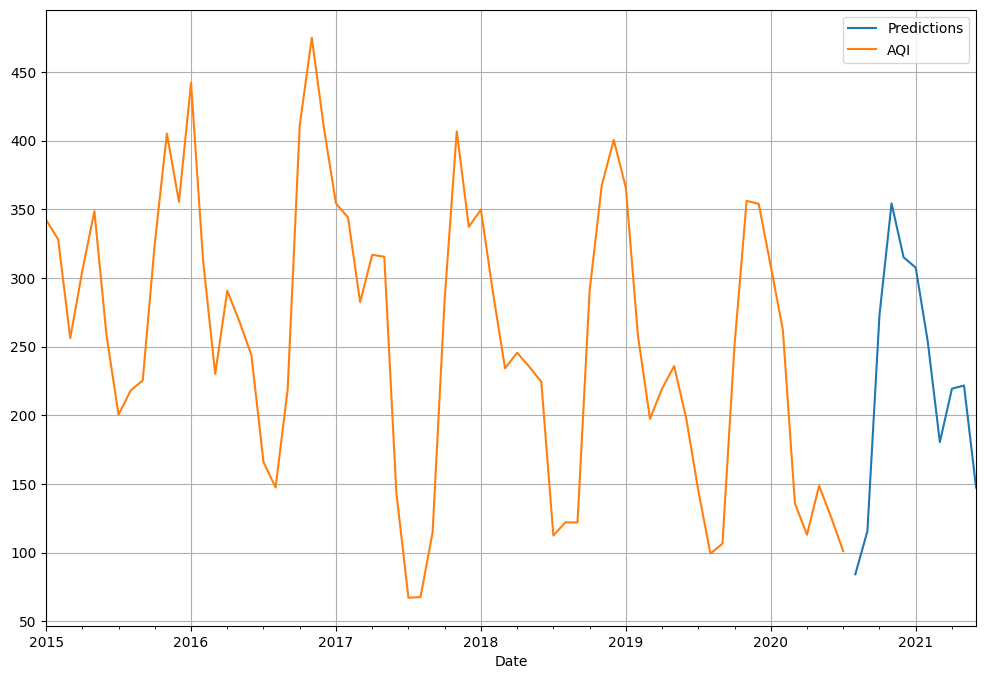

In [21]:
#Obtaining predicted values:
future_predictions = results.predict(start=67, end=77, typ='levels').rename('Predictions')

#Plotting predicted values against the true values:
future_predictions.plot(legend=True)
delhi_AQI.plot(legend=True,figsize=(12,8),grid=True)

### GRID search framework for fine tuning the model

In [22]:
def grid_search(p,d,q,P,D,Q,m,train,test):
    
    column_names = ['p','d','q','P','D','Q','m','RMSE_train','RMSE_test']
    df = pd.DataFrame(columns = column_names)

    for p1 in p:
        for p2 in d:
            for p3 in q:
                for p4 in P:
                    for p5 in D:
                        for p6 in Q:
                            for p7 in m:
                                
                                
                                model=SARIMAX(train,order=(p1,p2,p3),seasonal_order=(p4,p5,p6,p7))
                                try:
                                    results=model.fit()
                                except:
                                    print("Passing on : " + str(p1) + " " + str(p2) + " " + str(p3) + " " + str(p4) + " " + str(p5) + " " + str(p6) + " " + str(p7))
                                    pass
                                print("Fitting on : " + str(p1) + " " + str(p2) + " " + str(p3) + " " + str(p4) + " " + str(p5) + " " + str(p6) + " " + str(p7))
                                #results.summary()
                                #Predicting on our train and test dataset
                                train_predictions = results.predict(start=1, end=48, typ='levels').rename('Predictions')
                                test_predictions = results.predict(start=48, end=60, typ='levels').rename('Predictions')
                                
                                #Calculating the RMSE value on the training dataset 
                                RMSE_train = np.sqrt(mean_squared_error(train_predictions,train))
                                #Calculating the RMSE value on the testing dataset 
                                RMSE_test=np.sqrt(mean_squared_error(test_predictions,test))
                                
                                #Fill our dataframe
                                df = df.append({'p':p1, 'd':p2,'q':p3,
                                                'P':p4,'D':p5,'Q':p6,'m':p7,
                                                'RMSE_train' : RMSE_train, 'RMSE_test' : RMSE_test},
                                               ignore_index = True)
                                print(df.tail(1))
                                
                                
                                
    return df

In [26]:
train=delhi_AQI[:48]
test=delhi_AQI[48:61]

delhi_AQI.dropna(inplace=True)

p = [1,2,3,0]
d = [1,2,3,0]
q = [1,2,3,0]
P = [1,2,3,0]
D = [1,2,3,0]
Q = [1,2,3,0]
m = [12]

warnings.filterwarnings("ignore")

table = grid_search(p, d, q, P, D, Q, m, train, test)

print(table)  


Fitting on : 1 1 1 1 1 1 12
     p    d    q    P    D    Q     m  RMSE_train  RMSE_test
0  1.0  1.0  1.0  1.0  1.0  1.0  12.0   62.975715  37.275076
Fitting on : 1 1 1 1 1 2 12
     p    d    q    P    D    Q     m  RMSE_train  RMSE_test
1  1.0  1.0  1.0  1.0  1.0  2.0  12.0   63.135875  46.548277
Fitting on : 1 1 1 1 1 3 12
     p    d    q    P    D    Q     m  RMSE_train  RMSE_test
2  1.0  1.0  1.0  1.0  1.0  3.0  12.0   62.958166  44.394289
Fitting on : 1 1 1 1 1 0 12
     p    d    q    P    D    Q     m  RMSE_train  RMSE_test
3  1.0  1.0  1.0  1.0  1.0  0.0  12.0    66.41462  44.756889
Fitting on : 1 1 1 1 2 1 12
     p    d    q    P    D    Q     m  RMSE_train  RMSE_test
4  1.0  1.0  1.0  1.0  2.0  1.0  12.0   113.46711  66.679343
Fitting on : 1 1 1 1 2 2 12
     p    d    q    P    D    Q     m  RMSE_train  RMSE_test
5  1.0  1.0  1.0  1.0  2.0  2.0  12.0  113.541836  58.718145
Fitting on : 1 1 1 1 2 3 12
     p    d    q    P    D    Q     m  RMSE_train  RMSE_test
6  1.0  1.0

In [ ]:
table

In [ ]:
table.to_csv("grid-search-results.csv")